#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `dataset_taxi.csv`. Количество заказов находится в столбце `num_orders`. Дата и время в столбце `datetime`.

## Подготовка

In [2]:
# импортирование всех нужных библиотек и фуцнкций 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller 

# игнорирование предупреждений 
warnings.filterwarnings('ignore') 

### Обзор данных

По первому взгляду на данные можно сказать:
* Не считая столбца 'datetime', который будет индексом, в данных присутствует лишь целевой признак 'num_orders', поэтому следует создать признаки. 
* Имеются данные о заказах 'num_orders' с промежутком в 10 минут.
* Пропущенные значения отсутствуют.


In [5]:
# формирование датафрейма
data = pd.read_csv('dataset_taxi.csv', index_col=0)

# проверка внесенных изменений 
display(data.head())
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 621.0+ KB


### Подготовка индекса
В качестве индекса установим столбец 'datetime'.

In [479]:
# изменения типа данных на 'datetime'
data['datetime'] = pd.to_datetime(data['datetime'])

# установка и сортировка индекса
data = data.set_index('datetime').sort_index()

# проверка внесенных изменений 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Ресемплирование
Так как задача модели - предсказание количества заказов на следующий час, агрегированное значение будет сумма заказов.

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


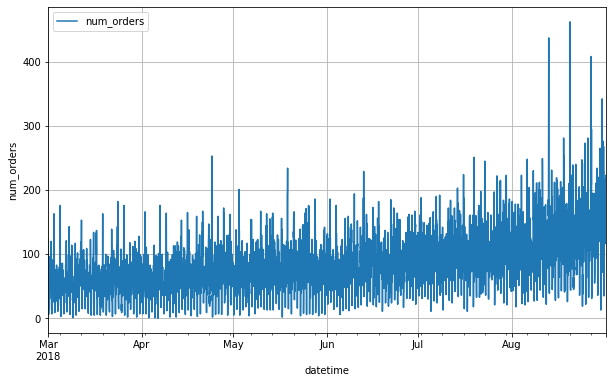

In [480]:
# ресемплирование данных по часу
data = data.resample('1H').sum()

# проверка внесенных изменений 
display(data.head())

# линейный график ресемплированных данных 
ax = data.plot(grid=True, figsize=(10, 6))
ax.set_xlabel('datetime')
ax.set_ylabel('num_orders')
legend = ax.legend(loc='upper left')
plt.show()

### Скользящее среднее
Имеет умеренно восходящий тренд.

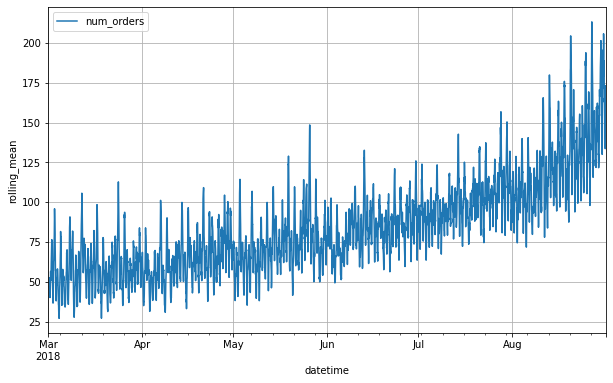

In [481]:
# линейный график скользящего среднего
ax = data['num_orders'].shift().rolling(10).mean().plot(figsize=(10, 6), grid=True)
ax.set_xlabel('datetime')
ax.set_ylabel('rolling_mean')
legend = ax.legend(loc='upper left')
plt.show()

### Скользящее стандартное отклонение
Стандартное отклонение скользящего стандартного отклонения значительно увеличивается с августа месяца.

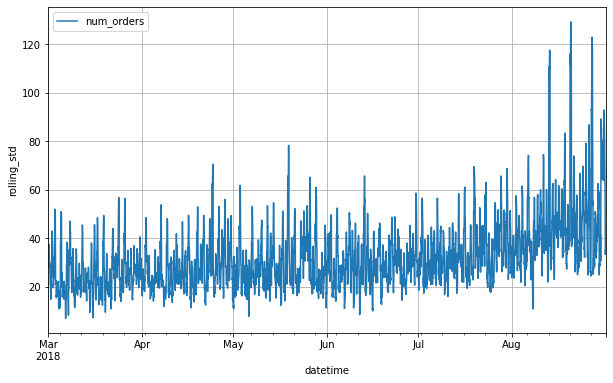

In [482]:
# линейный график скользящего стандартного отклонения 
ax = data['num_orders'].rolling(10).std().plot(figsize=(10, 6), grid=True)
ax.set_xlabel('datetime')
ax.set_ylabel('rolling_std')
legend = ax.legend(loc='upper left')
plt.show()

## Анализ
### Проверка ряда на стационарность
Воспользуемся тестом Дики — Фуллера для проверки ряда на стационарность, определим нулевую и альтернативную гипотезы. <br>
* **H0: Временной ряд нестационарный.** <br>
* **H1: Временной ряд стационарный.**<br>

Определим пороговое значение в 5%. <br>
После теста высянили, что ряд **стационарный**.

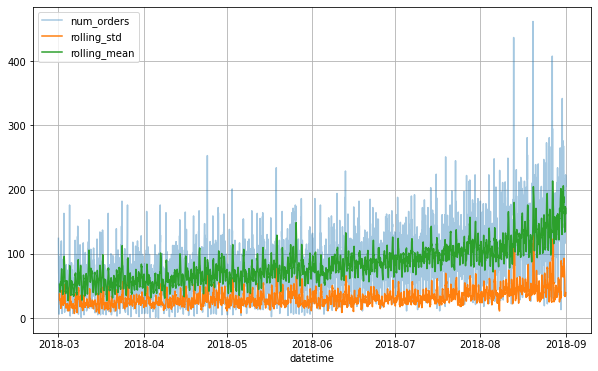

'pvalue = 0.028940051402612906, отвергаем нулевую гипотезу, ряд стационарный.'

In [483]:
# линейный график с цлевым признаком, скользящим средним и стандартным отклонением
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data['num_orders'], alpha=0.4, label='num_orders')
ax.plot(data['num_orders'].rolling(10).std(), label='rolling_std')
ax.plot(data['num_orders'].shift().rolling(10).mean(), label='rolling_mean')
ax.set_xlabel('datetime')
ax.legend(loc='upper left')
plt.grid()
plt.show()

# тест Дики - Фуллера
adfuller_test = adfuller(data['num_orders'])

# пороговое значение
alpha = .05

# проверка меньше ли p-value чем пороговое значение
if adfuller_test[1] < alpha:
    display('pvalue = ' + str(adfuller_test[1]) + ', отвергаем нулевую гипотезу, ряд стационарный.')
else:
    display('pvalue = ' + str(adfuller_test[1]) + ', не получилось отвергнуть нулевую гипотезу, ряд нестационарный.')

### Локация данных
Наибольшее количество значений находится в промежутке от 54 до 107 заказов. <br>
Слишком большие значения не стоит считать выбросами, так как в задаче необходимо предсказать *количество заказов на следующий час для привлечения таксистов в моменты **пиковой** загрузки*, поэтому их следует оставить.

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

<AxesSubplot:>

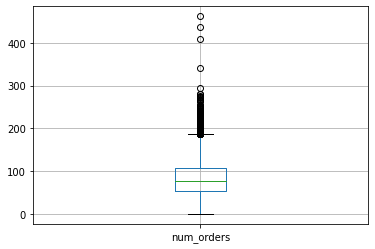

In [484]:
# описательные данные целевого признака
display(data['num_orders'].describe())

# диаграмма размаха по целевому признаку
display(data.plot(y='num_orders', kind='box', grid=True))

### Тренды и сезонность
* Тренд заметно увеличивается к осени.
* Явное падение количества заказов к 6:00, увеличение к 17:00 и пиковое значение в полночь.

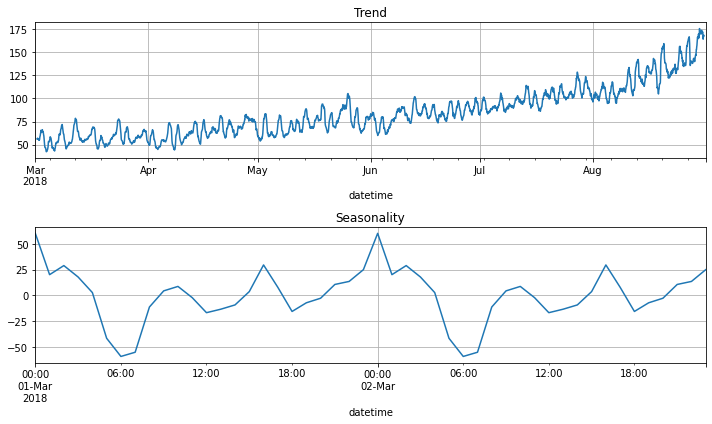

In [485]:
# разложение временного ряда на три составляющие
decomposed = seasonal_decompose(data)

# создание "фигуры"
plt.figure(figsize=(10,6))

# график тренда
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')

# график сезонности
plt.subplot(212)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(), grid=True)
plt.title('Seasonality')

# отображение графиков
plt.tight_layout()

### Формирование признаков
К двум имеющимся признакам добавим еще календарные признаки и отстающие значения. Удалим объекты с появившимися пропусками.

In [486]:
# функция формирования признаков 
def make_features(data, max_lag, rolling_size=10):

    # скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
    
    # календарные признаки 
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    
    # отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    return data

In [487]:
# вызов функции
make_features(data, 50)

# удаление пропущенных значений
data = data.dropna()

In [488]:
# проверка внесенных изменений
display(data.head())

,num_orders,rolling_mean,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,95.9,2,5,108.0,163.0,72.0,119.0,101.0,93.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-03 03:00:00,64,90.2,3,5,25.0,108.0,163.0,72.0,119.0,101.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-03 04:00:00,44,88.3,4,5,64.0,25.0,108.0,163.0,72.0,119.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-03 05:00:00,15,83.8,5,5,44.0,64.0,25.0,108.0,163.0,72.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-03 06:00:00,9,80.4,6,5,15.0,44.0,64.0,25.0,108.0,163.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


## Обучение
### Деление датафрейма
Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 8:1:1.

In [489]:
# формирование обучающей, валидационной и тестовой выборок
data_train, data_temporary = train_test_split(data, test_size=0.2, shuffle=False)
data_valid, data_test = train_test_split(data_temporary, test_size=0.5, shuffle=False)

In [490]:
# проверка соотношения размеров выборок
display(len(data_train), len(data_valid), len(data_test))

# проверка корректности разделения выборок
display(data_train.tail(2), data_valid.head(2), data_valid.tail(2), data_test.head(2))

3492

437

437

,num_orders,rolling_mean,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-26 12:00:00,102,105.8,12,3,86.0,142.0,138.0,80.0,39.0,21.0,...,81.0,118.0,120.0,112.0,114.0,116.0,64.0,93.0,88.0,94.0
2018-07-26 13:00:00,70,96.3,13,3,102.0,86.0,142.0,138.0,80.0,39.0,...,82.0,81.0,118.0,120.0,112.0,114.0,116.0,64.0,93.0,88.0


,num_orders,rolling_mean,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-26 14:00:00,53,89.2,14,3,70.0,102.0,86.0,142.0,138.0,80.0,...,113.0,82.0,81.0,118.0,120.0,112.0,114.0,116.0,64.0,93.0
2018-07-26 15:00:00,104,81.4,15,3,53.0,70.0,102.0,86.0,142.0,138.0,...,73.0,113.0,82.0,81.0,118.0,120.0,112.0,114.0,116.0,64.0


,num_orders,rolling_mean,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 17:00:00,152,119.9,17,0,144.0,175.0,102.0,119.0,92.0,144.0,...,174.0,155.0,89.0,105.0,84.0,102.0,62.0,122.0,174.0,143.0
2018-08-13 18:00:00,104,131.2,18,0,152.0,144.0,175.0,102.0,119.0,92.0,...,177.0,174.0,155.0,89.0,105.0,84.0,102.0,62.0,122.0,174.0


,num_orders,rolling_mean,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 19:00:00,91,132.5,19,0,104.0,152.0,144.0,175.0,102.0,119.0,...,157.0,177.0,174.0,155.0,89.0,105.0,84.0,102.0,62.0,122.0
2018-08-13 20:00:00,82,127.9,20,0,91.0,104.0,152.0,144.0,175.0,102.0,...,136.0,157.0,177.0,174.0,155.0,89.0,105.0,84.0,102.0,62.0


In [491]:
# признаки и целевой признак в обучающей выборке 
features_train = data_train.drop(['num_orders'], axis=1)
target_train = data_train['num_orders']

# признаки и целевой признак в валидационной выборке 
features_valid = data_valid.drop(['num_orders'], axis=1)
target_valid = data_valid['num_orders']

# признаки и целевой признак в тестовой выборке 
features_test = data_test.drop(['num_orders'], axis=1)
target_test = data_test['num_orders']

### Линейная регрессия

In [492]:
# модель 'линейная регрессия'
model_lin_reg = LinearRegression()

# обучение модели
model_lin_reg.fit(features_train, target_train)

# предсказания модели на валидационной выборке
pred_valid = model_lin_reg.predict(features_valid)

# RMSE модели на валидационной выборке
display(mean_squared_error(target_valid, pred_valid, squared=False))

31.733863999481823

### Случайный лес 

In [493]:
# вариации гиперпараметров
max_depth = [int(x) for x in np.linspace(10, 50, num = 3)]
n_estimators = [int(x) for x in np.linspace(10, 100, num = 3)]

# сетка гиперпараметров
param_grid = {'max_depth':max_depth,
              'n_estimators':n_estimators}

# параметр кросс-валидации для временных рядов 
tscv = TimeSeriesSplit(n_splits=8)

# модель 'случайный лес'
model_forest = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, 
                            scoring='neg_root_mean_squared_error', cv=tscv)
# обучение модели
model_forest.fit(features_train, target_train)

# предсказания модели на валидационной выборке
pred_valid = model_forest.predict(features_valid)

# RMSE модели на валидационной выборке
display(mean_squared_error(target_valid, pred_valid, squared=False))

32.23124481159955

### CatBoostRegressor

In [494]:
# вариации гиперпараметров
loss_function = ['RMSE']
max_depth = [int(x) for x in np.linspace(10, 50, num = 3)]
iterations = [int(x) for x in np.linspace(10, 100, num = 3)]

# сетка гиперпараметров
param_grid = {'n_estimators':n_estimators,
              'loss_function':loss_function,
              'max_depth':max_depth}

# модель 'CatBoostRegressor'
model_cat = GridSearchCV(CatBoostRegressor(), param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=tscv)

# обучение модели
model_cat.fit(features_train, target_train, verbose=100)

# предсказания модели на валидационной выборке
pred_valid = model_cat.predict(features_valid)

# RMSE модели на валидационной выборке
display(mean_squared_error(target_valid, pred_valid, squared=False))

Learning rate set to 0.5
0:	learn: 23.7021761	total: 50.9ms	remaining: 458ms
9:	learn: 9.3931238	total: 480ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 23.6600314	total: 56.3ms	remaining: 507ms
9:	learn: 10.9693834	total: 559ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 23.9530442	total: 61.6ms	remaining: 554ms
9:	learn: 11.7407918	total: 606ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 24.8233904	total: 67.6ms	remaining: 608ms
9:	learn: 13.0819845	total: 668ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 25.2598172	total: 70.7ms	remaining: 636ms
9:	learn: 13.5105804	total: 709ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 25.5576300	total: 78.4ms	remaining: 705ms
9:	learn: 14.1644060	total: 795ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.4658366	total: 96.7ms	remaining: 870ms
9:	learn: 14.4085562	total: 805ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.7468827	total: 84.4ms	remaining: 760ms
9:	learn: 15.9163901	total: 828ms	remainin

34.35749409003977

### Сравнение моделей
Наименьшую ошибку RMSE на валидационной выборке с изменением количества отстающих значений показывает <br>
**модель 'линейная регрессия' - 31.73**. 

In [496]:
# датафрейм с результатами моделей 
models_stats = pd.DataFrame(data={'RMSE_valid_8_lags':[42.47, 32.48, 34.40], 
                                  'RMSE_valid_10_lags':[42.41, 32.19, 34.20], 
                                  'RMSE_valid_15_lags':[41.50, 31.74, 32.35], 
                                  'RMSE_valid_25_lags':[34.47, 31.94, 32.83], 
                                  'RMSE_valid_50_lags':[31.73, 32.23, 34.35]}, 
                            index=['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'])
display(models_stats)
display(models_stats.min().min())

,RMSE_valid_8_lags,RMSE_valid_10_lags,RMSE_valid_15_lags,RMSE_valid_25_lags,RMSE_valid_50_lags
LinearRegression,42.47,42.41,41.50,34.47,31.73
RandomForestRegressor,32.48,32.19,31.74,31.94,32.23
CatBoostRegressor,34.40,34.20,32.35,32.83,34.35


31.73

### Проверка выбранной модели на адекватность
Для проверки модели на адекватность сравним ее с предсказаниями без обучения. <br>
Используем способ прогнозирования нового элемента x(t) предыдущим элементом x(t-1). <br>
Модель показывает ошибку RMSE меньше, нежели ошибка прогноза без обучения, следовательно выбранная модель адекватна.


In [497]:
# прогнозирование нового элемента предыдущим
pred_previous = data_test['num_orders'].shift()

# замена первого пропущенного значение в тестовой выборке последним из обучающей выборки
pred_previous.iloc[0] = data_train['num_orders'].iloc[-1]

# RMSE предсказаний на тестовой выборке
display(mean_squared_error(target_test, pred_previous, squared=False))

59.02431333965175

## Тестирование

In [498]:
# предсказания выбранной модели на тестовой выборке
pred_test = model_lin_reg.predict(features_test)

# RMSE выбранной модели на тестовой выборке
display(mean_squared_error(target_test, pred_test, squared=False))

42.30224424304047

## Вывод
* Провели первичный обзор данных.
* В качества индекса установили столбец 'datetime', отсортировали его и ресемплировали по часу.
* Посмотрели линейные графики скользящего среднего и скользящего стандартного отклонения.
* Выяснили, что имеющийся ряд стационарный.
* Посмотрели описательные данные и диаграмму размаха целевого признака.
* Провели анализ на тренд и сезонность.
* Сформировали новые признаки: календарные признаки, отстающие значения и скользящее среднее.
* Разделили данные на обучающую, валидационную и тестовую выборки в соотношении 8:1:1 соответственно.
* Обучили и сравнили между собой три разные модели: 'линейная регрессия', 'случайный лес', 'CatBoostRegressor'. Подобрали наилучшую модель по RMSE ошибке с изменяющимся количеством отстающих значений - 'линейная регрессия'.
* Провели проверку выбранной модели на адекватность, путем сравнения ее показателей с показателями прогноза без обучения. Выбранный способ прогноза без обучения - предсказания нового элемента x(t) предыдущим элементом x(t-1).
* Протестировали выбранную модель на тестовой выборке. **Конечная RMSE ошибка модели на тестовых данных: 42.30**.